In [1]:
%matplotlib notebook
%config InlineBackend.print_figure_kwargs = {'bbox_inches':None}

from mpl_toolkits import mplot3d
import matplotlib.pyplot as plt
from os import path
import numpy as np
import cv2 as cv
import trimesh
import os

# Our local modules
import src.calibrate as clb
import src.util as util

# Check that we're in the correct folder

For the code in this notebook to work correctly, the Jupyter server must be started from the `endoscope-calibration` folder. Then you put all of your data in the `./endoscope-calibration/data/`. 

In [2]:
# Check that we're in the right directory
base_dir_name = 'endoscope-calibration'
cwd = os.getcwd()
if not cwd.endswith(base_dir_name):
    print('[WARNING] Your base directory is not \'{}\' - are you running '
          'Jupyter in the correct server?'.format(base_dir_name))
    
data_dir = path.join(cwd, 'data')

# Load the calibration image and mark relevant points

In [3]:
image_name = 'image-3.png'

# Positions of the markers in the image listed clockwise,
# starting from the blue marker at top left and finishing
# wit the green marker in bottom left
points_2d_raw = np.array([
#     [160, 527, 1147, 977, 570, 384], # image-2
#     [265, 167, 310, 736, 789, 786],
    [240, 425, 919, 923, 496, 346], # image-3
    [157, 67, 73, 600, 621, 621]
#     [89, 290, 786, 737, 359, 214], # image-4
#     [249, 175, 228, 657, 702, 705],
])
point_count = points_2d_raw.shape[1]

# Define point colours explicitly - makes it easier to
# ensure the image-points <-> mesh-points mapping is
# correct
point_colours = ['red', 'black', 'gray', 'yellow', 'blue', 'green']

<IPython.core.display.Javascript object>


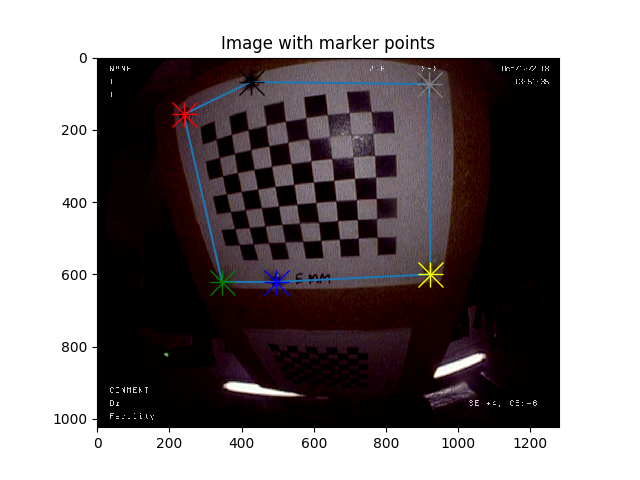

In [4]:
image_raw = cv.imread(path.join(data_dir, image_name))
image_raw = cv.cvtColor(image_raw, cv.COLOR_BGR2RGB)

fig, ax = plt.subplots(nrows=1, ncols=1)
ax.set_title('Image with marker points')
ax.imshow(image_raw)
util.draw_2d_points(ax, points_2d_raw, colour=point_colours,
                    connect=True, size=18)

# Load camera intrinsics and undistort the image

<IPython.core.display.Javascript object>


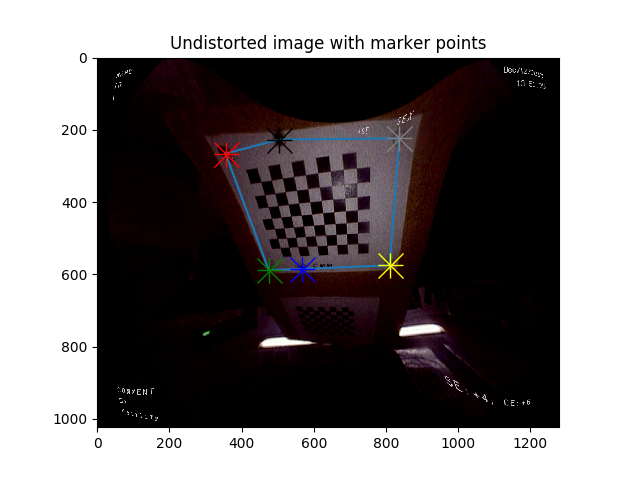

In [5]:
intrinsics_file = path.join(data_dir, 'refined_intrinsics.json')
cam_matrix, dist_coeffs = util.load_intrinsics(intrinsics_file)

h, w = image_raw.shape[:2]
new_cam_matrix, roi = cv.getOptimalNewCameraMatrix(cam_matrix, dist_coeffs,
                                                   (w, h), 1, (w, h))

image = cv.undistort(image_raw, cam_matrix, dist_coeffs, None, new_cam_matrix)
points_2d = util.undistort_line(points_2d_raw, cam_matrix,
                                      dist_coeffs, new_cam_matrix)

fig, ax = plt.subplots(nrows=1, ncols=1)
ax.set_title('Undistorted image with marker points')
ax.imshow(image)
util.draw_2d_points(ax, points_2d, colour=point_colours,
                    connect=True, size=18)

# Load relevant meshes

In [6]:
# Define mesh paths
brd_markers_file = path.join(data_dir, 'mesh1_board_markers.stl')
brd_file = path.join(data_dir, 'mesh6_board.stl')
end_markers_file = path.join(data_dir, 'mesh2_endoscope_markers.stl')
end_file = path.join(data_dir, 'mesh3_endoscope.stl')

# Load the meshes
brd_markers_joint = trimesh.load(brd_markers_file)
end_markers_joint = trimesh.load(end_markers_file)

# Get centroids for all calibration board and endoscope markers and ensure that the order is correct

In [7]:
brd_centroids_unordered = util.extract_marker_mesh_centroids(brd_markers_joint)
end_centroids = util.extract_marker_mesh_centroids(end_markers_joint)

# Reorder the points based on their coordinates in the visualisation below.
# Note that the order must match that of `img_points_cart`
brd_centroids = [None] * len(brd_centroids_unordered)
for centroid in brd_centroids_unordered:
    x, y, z = centroid
    if z > -80:
        # Top row
        if x < -160:
            brd_centroids[5] = centroid # Green marker
        elif x > -120:
            brd_centroids[3] = centroid # Yellow marker
        else:
            brd_centroids[4] = centroid # Blue marker
    else:
        # Bottom row
        if x < -160:
            brd_centroids[0] = centroid # Red marker
        elif x > -120:
            brd_centroids[2] = centroid # White marker
        else:
            brd_centroids[1] = centroid # Black marker
        

# Refine and visualise the points

<IPython.core.display.Javascript object>


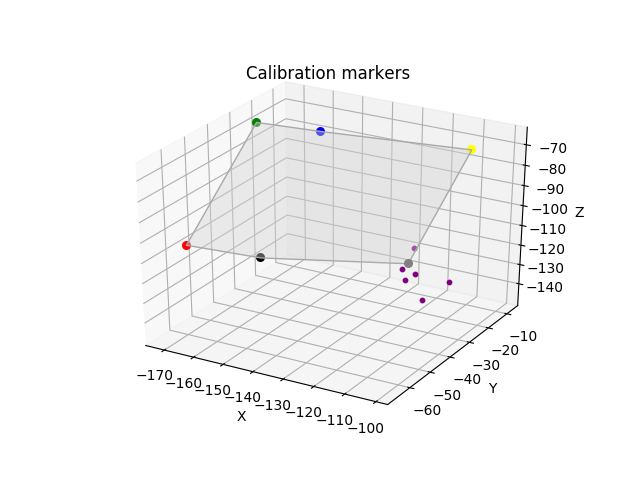

In [8]:
points_3d = np.array(brd_centroids).T
plane_normal = util.find_plane_normal(points_3d)
centroid = np.mean(points_3d, axis=1)

end_points_3d = np.array(end_centroids).T

_, ax = util.prepare_3d_plot(title='Calibration markers')
util.draw_3d_points(ax, points_3d, colour=point_colours, connect=True, size=30)
util.draw_3d_points(ax, end_points_3d, colour='purple')


# Estimate camera extrinsics from 2D-3D point correspondence

<IPython.core.display.Javascript object>


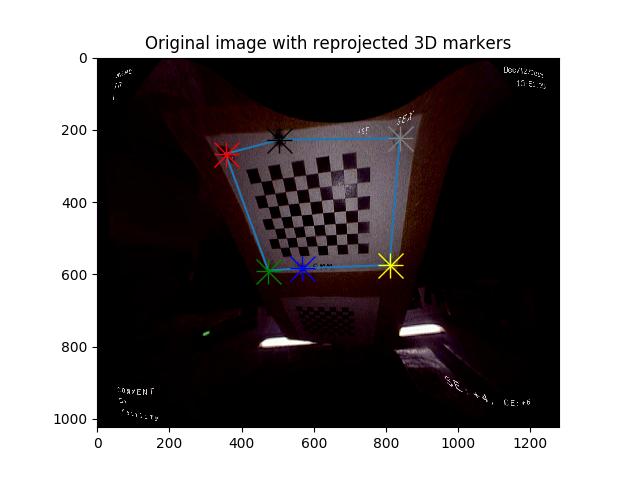

In [9]:
ret, rvec, tvec = cv.solvePnP(points_3d.T, points_2d.T, new_cam_matrix, None)
cv_points_2d = cv.projectPoints(points_3d.T, rvec, tvec, new_cam_matrix, None)[0]
new_points_2d = cv_points_2d[:, 0, :].T

fig, ax = plt.subplots(nrows=1, ncols=1)
ax.set_title('Original image with reprojected 3D markers')
ax.imshow(image)
util.draw_2d_points(ax, new_points_2d, colour=point_colours,
                    connect=True, size=18)

# Draw camera alongside the meshes

<IPython.core.display.Javascript object>


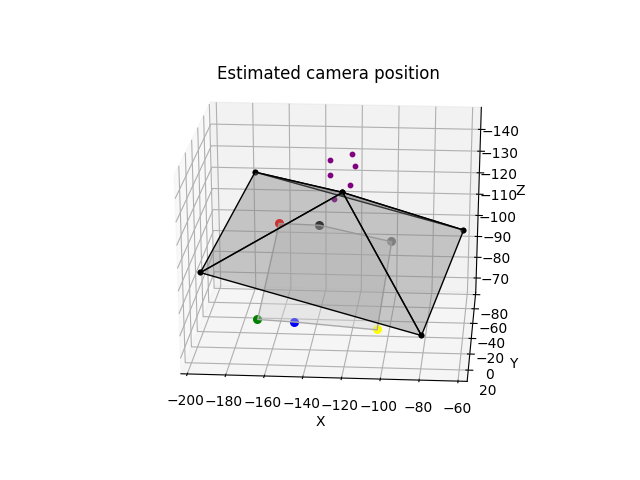

In [13]:
R = cv.Rodrigues(rvec)[0]
t = tvec.reshape(3, 1)

_, ax = util.prepare_3d_plot(title='Estimated camera position')
util.draw_3d_points(ax, points_3d, colour=point_colours, connect=True, size=30)
util.draw_3d_points(ax, end_points_3d, colour='purple')
util.draw_3d_camera(ax, w, h, new_cam_matrix, R, t, z=30)